In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations
from itertools import chain
from collections import namedtuple
import pickle
import os.path

import sys
import numpy as np
import math
import random

from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Bidirectional, Input, concatenate
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, AveragePooling1D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.advanced_activations import PReLU
from sklearn.metrics import average_precision_score, roc_auc_score


Using TensorFlow backend.


In [2]:
#Download DeepPASTA Models

#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/brain/DeepPASTA_relatively_brain_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/kidney/DeepPASTA_relatively_kidney_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/liver/DeepPASTA_relatively_liver_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/maqc_brain1/DeepPASTA_relatively_maqc_brain1_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/maqc_brain2/DeepPASTA_relatively_maqc_brain2_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/maqc_UHR1/DeepPASTA_relatively_maqc_UHR1_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/maqc_UHR2/DeepPASTA_relatively_maqc_UHR2_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/muscle/DeepPASTA_relatively_muscle_learned.hdf5
#!wget http://www.cs.ucr.edu/~aaref001/trained_models/tissue_specific_relatively_dominant/tissue_set_one/testis/DeepPASTA_relatively_testis_learned.hdf5


In [3]:
def seqEncoder(rawSeqList):
    if len(rawSeqList) != 0:
        encodedSeq = np.zeros((len(rawSeqList), len(rawSeqList[0]), 5))
        for i in range(len(rawSeqList)):
            sequence = rawSeqList[i]
            j = 0
            for s in sequence:
                if s == 'A' or s == 'a':
                    encodedSeq[i][j] = [1,0,0,0,0]
                elif s == 'T' or s == 't':
                    encodedSeq[i][j] = [0,1,0,0,0]
                elif s == 'C' or s == 'c':
                    encodedSeq[i][j] = [0,0,1,0,0]
                elif s == 'G' or s == 'g':
                    encodedSeq[i][j] = [0,0,0,1,0]
                elif s == 'N' or s == 'n':
                    encodedSeq[i][j] = [0,0,0,0,1]
                else:
                    print>>sys.stderr, 'ERROR: Unwanted nucleotide: ' + s
                j = j + 1
        return encodedSeq
    else:
        return 0

def structEncoder(rawStructureList):
    if len(rawStructureList) != 0:
        encodedStructure = np.zeros((len(rawStructureList), len(rawStructureList[0]), 7))
        for i in range(len(rawStructureList)):
            structure = rawStructureList[i]
            j = 0
            for s in structure:
                if s == 'U':
                    encodedStructure[i][j] = [1,0,0,0,0,0,0]
                elif s == 'E':
                    encodedStructure[i][j] = [0,1,0,0,0,0,0]
                elif s == 'L':
                    encodedStructure[i][j] = [0,0,1,0,0,0,0]
                elif s == 'R':
                    encodedStructure[i][j] = [0,0,0,1,0,0,0]
                elif s == 'H':
                    encodedStructure[i][j] = [0,0,0,0,1,0,0]
                elif s == 'M':
                    encodedStructure[i][j] = [0,0,0,0,0,1,0]
                elif s == 'I':
                    encodedStructure[i][j] = [0,0,0,0,0,0,1]
                else:
                    print>>sys.stderr, 'Warning: Unwanted character ' + s
                j = j + 1
        return encodedStructure
    else:
        return 0

def sequenceModel(seqInput):
    seqCov = Conv1D(filters=256,
        kernel_size=8,
        padding = "valid",
        input_shape =(200, 5),
        strides=1)(seqInput) 

    activa_conv = PReLU(alpha_initializer = 'zero', weights = None)(seqCov)

    seqPool = MaxPooling1D(pool_size = 10, strides = 5)(activa_conv)
    seqPoolDout = Dropout(rate = 0.2)(seqPool)

    seqBiLstm = Bidirectional(LSTM(units = 128, return_sequences = True))(seqPoolDout)
    seqBiLstmDout = Dropout(rate = 0.5)(seqBiLstm)
    seqFlat = Flatten()(seqBiLstmDout)

    seqDen1 = Dense(256, kernel_initializer='glorot_uniform', activation = 'relu')(seqFlat)
    seqDout1 = Dropout(rate = 0.5)(seqDen1)

    return seqDout1

def combinedModel(seqInput, structInput):
    layer_list = []

    layer_list.append(sequenceModel(seqInput))

    layer_list.append(structureModel(structInput))
    merged_layer = concatenate(layer_list)

    comDen1 = Dense(128, kernel_initializer='glorot_uniform', activation = 'relu')(merged_layer)
    comDout1 = Dropout(rate = 0.5)(comDen1)


    comDen2 = Dense(64, kernel_initializer='glorot_uniform', activation = 'relu')(comDout1)
    comDout2 = Dropout(rate = 0.5)(comDen2)

    comDen4 = Dense(1, kernel_initializer='glorot_uniform')(comDout2)

    return comDen4


def structureModel(structInput):
    structCov = Conv1D(filters = 16,
               kernel_size = 12,
               padding = 'valid',
               activation = 'relu',
               strides = 1)(structInput)

    structPool = AveragePooling1D(pool_size = 20, strides = 10)(structCov)
    structPoolDout = Dropout(rate=0.2)(structPool)

    structBiLstm = Bidirectional(LSTM(units = 8, return_sequences = True))(structPoolDout)
    structBiLstmDout = Dropout(rate = 0.5)(structBiLstm)
    structFlat = Flatten()(structBiLstmDout)

    structDen1 = Dense(2, kernel_initializer='glorot_uniform')(structFlat)
    structActivaDen1 = PReLU(alpha_initializer = 'zero', weights= None)(structDen1)
    structDout1 = Dropout(rate=0.9)(structActivaDen1)

    return structDout1


In [4]:

def get_predict_func(model_file) :
    
    # Building deep learning model 
    training_net = []
    # deep learning sub-model for sequence
    seqInput1 = Input(shape = (200, 5))
    structInput1 = Input(shape = (200, 7))
    comModel1 = combinedModel(seqInput1, structInput1)
    training_net.append(comModel1)
    # deep learning sub-model for structure
    seqInput2 = Input(shape = (200, 5))
    structInput2 = Input(shape = (200, 7))
    comModel2 = combinedModel(seqInput2, structInput2)
    training_net.append(comModel2)
    merged_model = concatenate(training_net)

    den1_1 = Dense(2, activation = 'softmax')(merged_model)

    model = Model(inputs = [seqInput1,structInput1, seqInput2,structInput2], outputs = den1_1)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.load_weights(model_file)
    
    def _predict(testingSequenceList1, testingSequenceList2, testingStructList1, testingStructList2) :
        
        encodedTesting1 = seqEncoder(testingSequenceList1)
        encodedTesting2 = seqEncoder(testingSequenceList2)

        encodedTestingStructure1 = structEncoder(testingStructList1)
        encodedTestingStructure2 = structEncoder(testingStructList2)

        testingData = []
        testingData.append(encodedTesting1)
        testingData.append(encodedTestingStructure1)
        testingData.append(encodedTesting2)
        testingData.append(encodedTestingStructure2)

        preds = model.predict(testingData, batch_size = 100, verbose = 0)

        return preds
    
    return _predict

tissue_types = [
    'brain',
    'kidney',
    'liver',
    'maqc_brain1',
    'maqc_brain2',
    'maqc_UHR1',
    'maqc_UHR2',
    'muscle',
    'testis',
]

model_files = ["DeepPASTA_relatively_" + tissue_type + "_learned.hdf5" for tissue_type in tissue_types]

predict_funcs = [get_predict_func(model_file) for model_file in model_files]


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#Load dataframe of sequences to predict APA for

df = pd.read_csv('../PolyApredictors/apa_leslie_derti_apadb_pair_data_df_pair.csv', sep='\t')


In [5]:
#Pad sequences to fit DeepPASTA input format

df['seq_p'] = df['wide_seq_ext_prox'].str.slice(175-70, 175-70+205-5)
df['seq_d'] = df['wide_seq_ext_dist'].str.slice(175-70, 175-70+205-5)


In [7]:
#Generate RNA structures

with open("test1_p.fa", "wt") as temp_f :
    i = 0
    for _, row in df.iterrows() :
        temp_f.write(">seq" + str(i) + "\n" + row['seq_p'] + "\n")
        i += 1

!./generating_secondary_structure_from_sequence/RNAshapes -f ./test1_p.fa -s -c 5 -t 1 -w 100 -W 100 -O 'D{%s\n}' > temp_shapes1.txt
!python2 ./generating_secondary_structure_from_sequence/combining_substructure.py -i temp_shapes1.txt -o temp_shapes2.txt
!python2 ./generating_secondary_structure_from_sequence/filtering_number_of_ss.py -n 1 -i temp_shapes2.txt -o temp_shapes3.txt
!python2 ./generating_secondary_structure_from_sequence/shape_assign_per_nucleotide.py -c 1 -i temp_shapes3.txt -o temp_shapes4_p.txt

structs_prox_p = []
with open("temp_shapes4_p.txt", "rt") as temp_f :
    i = 0
    for line in temp_f.readlines() :
        if i % 2 == 1 :
            struct_prox = line.strip()
            structs_prox_p.append(struct_prox)
        i += 1


Starting program ...
Output from RNAshapes: temp_shapes1.txt
Output filename: temp_shapes2.txt
Starting program ...
Number of suboptimal structures considered: 1
Output from RNAshapes: temp_shapes2.txt
Output filename: temp_shapes3.txt
Starting program ...
Number of structure: 1
Output from RNAshapes to assign structure: temp_shapes3.txt
Output file name: temp_shapes4_p.txt


In [8]:
#Generate RNA structures

with open("test1_d.fa", "wt") as temp_f :
    i = 0
    for _, row in df.iterrows() :
        temp_f.write(">seq" + str(i) + "\n" + row['seq_d'] + "\n")
        i += 1

!./generating_secondary_structure_from_sequence/RNAshapes -f ./test1_d.fa -s -c 5 -t 1 -w 100 -W 100 -O 'D{%s\n}' > temp_shapes1.txt
!python2 ./generating_secondary_structure_from_sequence/combining_substructure.py -i temp_shapes1.txt -o temp_shapes2.txt
!python2 ./generating_secondary_structure_from_sequence/filtering_number_of_ss.py -n 1 -i temp_shapes2.txt -o temp_shapes3.txt
!python2 ./generating_secondary_structure_from_sequence/shape_assign_per_nucleotide.py -c 1 -i temp_shapes3.txt -o temp_shapes4_d.txt

structs_dist_d = []
with open("temp_shapes4_d.txt", "rt") as temp_f :
    i = 0
    for line in temp_f.readlines() :
        if i % 2 == 1 :
            struct_dist = line.strip()
            structs_dist_d.append(struct_dist)
        i += 1


Starting program ...
Output from RNAshapes: temp_shapes1.txt
Output filename: temp_shapes2.txt
Starting program ...
Number of suboptimal structures considered: 1
Output from RNAshapes: temp_shapes2.txt
Output filename: temp_shapes3.txt
Starting program ...
Number of structure: 1
Output from RNAshapes to assign structure: temp_shapes3.txt
Output file name: temp_shapes4_d.txt


In [9]:
#Execute all tissue-specific APA predictors on each sequence

testingSequenceList_p = [row['seq_p'] for _, row in df.iterrows()]
testingSequenceList_d = [row['seq_d'] for _, row in df.iterrows()]
testingStructList_p = structs_prox_p
testingStructList_d = structs_dist_d

y_pred_tissues = []
for tissue_type_ix, tissue_type in enumerate(tissue_types) :
    y_pred = predict_funcs[tissue_type_ix](testingSequenceList_p, testingSequenceList_d, testingStructList_p, testingStructList_d)[:, 0][:, None]
    y_pred_tissues.append(y_pred)


In [10]:
#Calculate isoform log odds

logodds_pred_tissues = []
for tissue_type_ix, tissue_type in enumerate(tissue_types) :
    logodds_pred = np.log(y_pred_tissues[tissue_type_ix] / (1. - y_pred_tissues[tissue_type_ix]))
    
    logodds_pred_tissues.append(logodds_pred)


In [12]:
#Store predictions in df

for tissue_type_ix, tissue_type in enumerate(tissue_types) :
    y_pred = y_pred_tissues[tissue_type_ix]
    logodds_pred = logodds_pred_tissues[tissue_type_ix]
    
    df['iso_pred_' + tissue_type] = np.ravel(y_pred)
    df['logodds_pred_' + tissue_type] = np.ravel(logodds_pred)

df['usage_prox'] = np.mean(np.concatenate(y_pred_tissues, axis=1), axis=1)
df['score_prox'] = np.mean(np.concatenate(logodds_pred_tissues, axis=1), axis=1)
df['score_dist'] = 0.


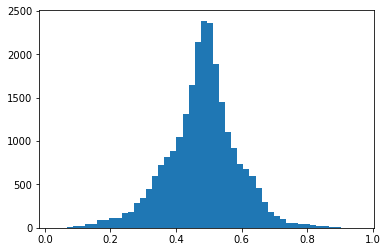

In [26]:
import matplotlib.pyplot as plt

f = plt.figure()

plt.hist(y_pred_tissues[0], bins=50)

plt.show()


In [13]:
#Re-save prediction df

df[['gene_id', 'seq_prox', 'seq_dist', 'usage_prox', 'score_prox', 'score_dist']].to_csv("apa_leslie_derti_apadb_pair_data_df_pair_deeppasta.csv", sep='\t', index=False)
